# Report for Classification Model of Time Deposit Renewal by Random Forest

### Written by Hao Zhu

This report is based on the data set related to the deposit and bank account. By building up a classification model of time deposit renewal, this report analyzes how different factors influence the customers' intention on deposit renewal.

The following are the detailed steps of the model build-up including the data mining and data visualization.

First import the package needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
%matplotlib inline

Then import the data set

In [2]:
df = pd.read_csv("Data Science Applicant Assignment - Mock Data.csv")
df

,CDRenewal,CDNumber,MaturingTerm,MaturingTermGrouping,MaturingBalance,TimeRenewed,CDAge,BA_STATE,CustomerTenure,LifeStageGroupCat,...,AdditCDCount,LOAN_COUNT,LOAN_BALANCE,POB_INT,MB_INT,IVR_INT,FF,CDAdvertisingSpend,BankAdvertisingSpend,RateSpread
0,0,MOCKACCT000000000002,10,7-15 months,50468.92,0,0,TX,0,Unassigned,...,0,0,0.0,0,0,0,0.66,0.0,0.00,1.093380
1,1,MOCKACCT000000000003,10,7-15 months,40000.00,0,0,TX,1,Younger Years,...,1,0,0.0,0,0,0,0.66,0.0,0.00,1.093380
2,1,MOCKACCT000000000004,18,16-24 months,31275.10,0,1,FL,3,Younger Years,...,1,0,0.0,0,0,0,0.66,0.0,0.00,1.492100
3,1,MOCKACCT000000000005,10,7-15 months,171594.32,0,0,TX,0,Mature Years,...,1,0,0.0,1,0,0,0.66,0.0,0.00,1.093380
4,1,MOCKACCT000000000006,18,16-24 months,50000.00,0,1,FL,2,Family Life,...,3,0,0.0,0,0,0,0.66,0.0,0.00,1.492100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21316,0,MOCKACCT000000021318,60,25+ months,52806.61,0,0,TX,2,Mature Years,...,2,0,0.0,0,0,0,1.58,0.0,4591.08,1.786225
21317,0,MOCKACCT000000021319,60,25+ months,52806.61,0,0,TX,2,Mature Years,...,2,0,0.0,0,0,0,1.58,0.0,4591.08,1.786225
21318,0,MOCKACCT000000021320,60,25+ months,52806.61,0,0,TX,2,Mature Years,...,2,0,0.0,0,0,0,1.58,0.0,4591.08,1.786225
21319,0,MOCKACCT000000021321,60,25+ months,52792.56,0,0,TX,2,Mature Years,...,2,0,0.0,0,0,0,1.58,0.0,4591.08,1.786225


According to the data dictionary, do some data mining first. Column 'CDRenewal' is the label column we need. Column 'CDNumber' as the unique index here is not useful here. After checking no duplicity, drop this column. Column 'LifeStageGroupCat', 'LifeStageGroupSubcat', 'PsycleCodeDescrip' are relevant with each other 'LifeStageGroupCat' does not have much information compared to 'LifeStageGroupSubcat'. 'PsycleCodeDescrip' has too many categories which is hard to classify. Here we choose 'LifeStageGroupSubcat' and drop other two columns. For the unassigned class in 'LifeStageGroupSubcat', there is only 772 rows which is 3.5% of the entire data set, drop this class which does not have too much information.

In [3]:
df.drop('CDNumber', axis = 1, inplace = True)
df.drop('PsycleCodeDescrip', axis = 1, inplace = True)
df.drop('LifeStageGroupCat', axis = 1, inplace = True)

Column 'MaturingTermGrouping' has miss value when 'MaturingTerm' equals to 25. Here we fill the missing value in 'MaturingTermGrouping', use the 'MaturingTermGrouping' and drop 'MaturingTerm'. Becuase 'MaturingTermGrouping' has less classes which is better fit the model and for the analysis.

In [4]:
df['MaturingTermGrouping'].fillna(value = '25+ months', inplace = True)
df.drop('MaturingTerm', axis = 1, inplace = True)

Then check the abnormal data in each column. Column 'MaturingBalance', 'CDAge', 'TRAN_BALANCE' and 'CustomerTenure' have negative numbers which is meaningless, drop the negative numbers.

In [5]:
data = df[(df['MaturingBalance'] >= 0) & (df['CustomerTenure'] >= 0) & (df['CDAge'] >= 0) & (df['LifeStageGroupSubcat'] != 'Unassigned')]

Show the data set after data mining. The dataframe has 20544 rows * 20 columns.

In [6]:
data

,CDRenewal,MaturingTermGrouping,MaturingBalance,TimeRenewed,CDAge,BA_STATE,CustomerTenure,LifeStageGroupSubcat,TRAN_COUNT,TRAN_BALANCE,AdditCDCount,LOAN_COUNT,LOAN_BALANCE,POB_INT,MB_INT,IVR_INT,FF,CDAdvertisingSpend,BankAdvertisingSpend,RateSpread
1,1,7-15 months,40000.00,0,0,TX,1,Y2 Metro Mainstream,0,0.00,1,0,0.0,0,0,0,0.66,0.0,0.00,1.093380
2,1,16-24 months,31275.10,0,1,FL,3,Y1 Upwardly Mobile,0,0.00,1,0,0.0,0,0,0,0.66,0.0,0.00,1.492100
3,1,7-15 months,171594.32,0,0,TX,0,M3 Upscale Empty Nests,0,0.00,1,0,0.0,1,0,0,0.66,0.0,0.00,1.093380
4,1,16-24 months,50000.00,0,1,FL,2,F2 Upscale Earners,0,0.00,3,0,0.0,0,0,0,0.66,0.0,0.00,1.492100
5,0,7-15 months,239746.26,0,0,FL,3,M1 Financial Elite,1,67373.84,0,0,0.0,1,0,0,0.60,0.0,0.00,1.192900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21316,0,25+ months,52806.61,0,0,TX,2,M5 Retirement Blues,0,0.00,2,0,0.0,0,0,0,1.58,0.0,4591.08,1.786225
21317,0,25+ months,52806.61,0,0,TX,2,M5 Retirement Blues,0,0.00,2,0,0.0,0,0,0,1.58,0.0,4591.08,1.786225
21318,0,25+ months,52806.61,0,0,TX,2,M5 Retirement Blues,0,0.00,2,0,0.0,0,0,0,1.58,0.0,4591.08,1.786225
21319,0,25+ months,52792.56,0,0,TX,2,M5 Retirement Blues,0,0.00,2,0,0.0,0,0,0,1.58,0.0,4591.08,1.786225


Next, set up model by random forest. Here I use the h2o package because it can directly deal with the categorical values and avoid the loss of information. For the h2o package, first set up the instance.

In [7]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,4 hours 3 mins
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_Nancy__b6xpzd
H2O cluster total nodes:,1
H2O cluster free memory:,720 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Convert the data frame to the h2o data frame.

In [8]:
data_h2o = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


Then define the label and the features. In order to do the classification, h2o requires the label's type is factor.

In [9]:
predictors = list(data_h2o.columns)[1:]
response = 'CDRenewal'
data_h2o[response] = data_h2o[response].asfactor()
predictors

['MaturingTermGrouping',
 'MaturingBalance',
 'TimeRenewed',
 'CDAge',
 'BA_STATE',
 'CustomerTenure',
 'LifeStageGroupSubcat',
 'TRAN_COUNT',
 'TRAN_BALANCE',
 'AdditCDCount',
 'LOAN_COUNT',
 'LOAN_BALANCE',
 'POB_INT',
 'MB_INT',
 'IVR_INT',
 'FF',
 'CDAdvertisingSpend',
 'BankAdvertisingSpend',
 'RateSpread']

Here this report uses the cross validation, so split the data set into train sets and test sets. The ratio is 80% train, 20% test.

In [10]:
train, test = data_h2o.split_frame(ratios = [.8], seed = 1111)

Model train. Choose 10 folds for cross validation. The number of trees is 200. Max tree depth is 20.

In [11]:
cd_rf = H2ORandomForestEstimator(
    model_id='cd_classification_rf',
    binomial_double_trees = True,
    nfolds = 10,
    ntrees=200,
    seed=1111,
    max_depth=20)
cd_rf.train(x = predictors, y = response, training_frame = train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


Apply the model to the test sets and get the model performance.

In [12]:
cd_rf.model_performance(test_data=test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.08195298285995517
RMSE: 0.2862743140066101
LogLoss: 0.2877399720804765
Mean Per-Class Error: 0.10179961687130334
AUC: 0.96258973996723
AUCPR: 0.9677734325261337
Gini: 0.9251794799344599

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5447852353748915: 


,,0,1,Error,Rate
0,0,1211.0,220.0,0.1537,(220.0/1431.0)
1,1,156.0,2426.0,0.0604,(156.0/2582.0)
2,Total,1367.0,2646.0,0.0937,(376.0/4013.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.544785,0.928080,210.0
1,max f2,0.405824,0.956004,257.0
2,max f0point5,0.636303,0.933552,177.0
3,max accuracy,0.559415,0.906803,205.0
4,max precision,0.999549,1.000000,0.0
5,max recall,0.070811,1.000000,375.0
6,max specificity,0.999549,1.000000,0.0
7,max absolute_mcc,0.559415,0.796051,205.0
8,max min_per_class_accuracy,0.619741,0.895877,183.0
9,max mean_per_class_accuracy,0.606654,0.898200,188.0



Gains/Lift Table: Avg response rate: 64.34 %, avg score: 63.78 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010466,0.996327,1.554222,1.554222,1.000000,0.998489,1.000000,0.998489,0.016266,0.016266,55.422153,55.422153
1,,2,0.020184,0.993007,1.554222,1.554222,1.000000,0.994690,1.000000,0.996660,0.015105,0.031371,55.422153,55.422153
2,,3,0.030152,0.988766,1.554222,1.554222,1.000000,0.990418,1.000000,0.994596,0.015492,0.046863,55.422153,55.422153
3,,4,0.040120,0.984088,1.554222,1.554222,1.000000,0.985967,1.000000,0.992453,0.015492,0.062355,55.422153,55.422153
4,,5,0.050087,0.979971,1.554222,1.554222,1.000000,0.982205,1.000000,0.990413,0.015492,0.077847,55.422153,55.422153
5,,6,0.100174,0.959075,1.531024,1.542623,0.985075,0.969590,0.992537,0.980002,0.076685,0.154531,53.102420,54.262287
6,,7,0.150012,0.940539,1.546450,1.543894,0.995000,0.950180,0.993355,0.970094,0.077072,0.231603,54.645043,54.389448
7,,8,0.200100,0.921644,1.554222,1.546479,1.000000,0.930831,0.995019,0.960266,0.077847,0.309450,55.422153,54.647946
8,,9,0.300025,0.882621,1.534842,1.542604,0.987531,0.902132,0.992525,0.940904,0.153369,0.462820,53.484221,54.260360
9,,10,0.399950,0.827669,1.503835,1.532918,0.967581,0.855360,0.986293,0.919531,0.150271,0.613091,50.383530,53.291756


From the results, the AUC is 0.96 which is relatively high. The confusion metric also means the high accuracy and precision. This key metrics shows this model is a good fit for the improved data set.

Then do the analysis and data visualization on the importance of features to assess the influence of different variables on the decision of deposit renewal.

In [13]:
m = h2o.get_model('cd_classification_rf')
m.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,LifeStageGroupSubcat,89894.859375,1.000000,0.113662
1,CustomerTenure,84343.851562,0.938250,0.106644
2,BankAdvertisingSpend,82452.437500,0.917210,0.104252
3,MaturingBalance,78807.203125,0.876660,0.099643
4,TimeRenewed,74924.343750,0.833466,0.094734
5,FF,74372.882812,0.827332,0.094036
6,RateSpread,63395.652344,0.705220,0.080157
7,AdditCDCount,56852.105469,0.632429,0.071883
8,TRAN_BALANCE,30008.771484,0.333821,0.037943
9,MaturingTermGrouping,29757.564453,0.331026,0.037625


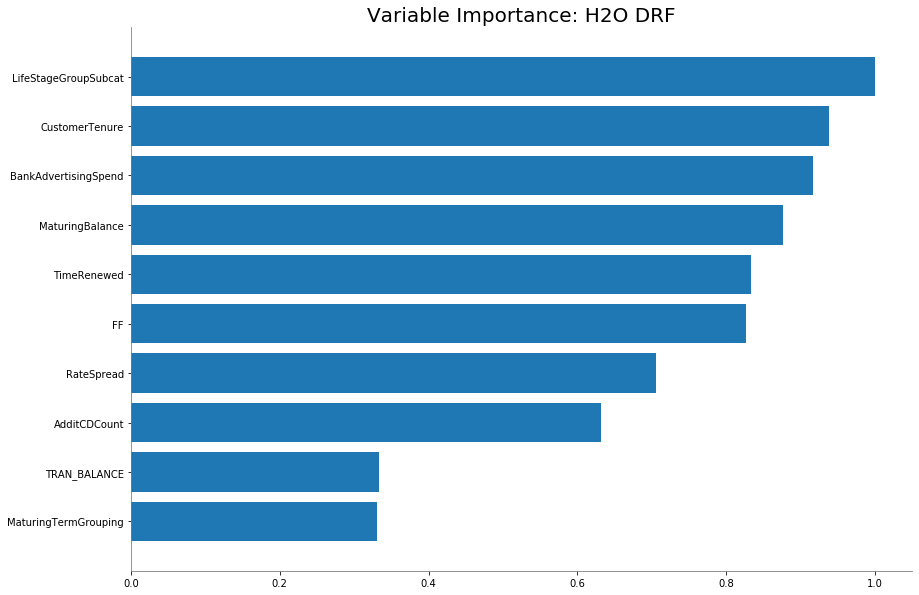

In [14]:
m.varimp_plot()

According to the graph, 'LifeStageGroupSubcat', 'CustomerTenure', 'BankAdvertisingSpend', 'MaturingBalanceRenewed' and 'FF' are the top 5 important variable also the importance is more than 80%.

Take top 1 variable as example, draw the table to show the relationship between variable and label.

In [16]:
renewal1 = data[data['CDRenewal'] == 1][['CDAge', 'LifeStageGroupSubcat']].groupby(['LifeStageGroupSubcat']).count()
total = data[['CDAge', 'LifeStageGroupSubcat']].groupby(['LifeStageGroupSubcat']).count()
percent = []
for i in range(12):
    percent.append(renewal1.iloc[i][0]/total.iloc[i][0])
pd.DataFrame(percent, renewal1.index, columns=['Deposit Renewal Percentage']).sort_values(by=['Deposit Renewal Percentage'])

,Deposit Renewal Percentage
LifeStageGroupSubcat,
F4 Working-Class USA,0.583732
M5 Retirement Blues,0.615724
Y1 Upwardly Mobile,0.627990
M2 Wealthy Achievers,0.635690
F3 Mass Middle Class,0.637119
Y2 Metro Mainstream,0.641694
F1 Flourishing Families,0.642157
M3 Upscale Empty Nests,0.644124
M1 Financial Elite,0.658263


From Table, we can see F2 Upscale Earners has the highest percentage which is most likely to renew the deposit while F4 Working-Class USA has the lowest percentage.